<a href="https://colab.research.google.com/gist/marcfrincu/c54136d6e8f02d5a02fd5e86c765ac01/simple_analytics_smartgrid_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Some simple analytics and smartgrid time series data

In this example we will perform some **simple analytics** on the consumption data that we have [previously cleaned](https://saveawatthour.com/index.php/2021/07/15/cleaning-up-smart-grid-data-with-examples/).
We will focus on:

1.  **Decomposing the time series** in its seasonal, trend, and residual components;
2.   **Checking if it is stationary** and **transforming it into a stationary time series** if we need to.

As usual we proceed by importing the relevant packages:

In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Next we upload our *test-cleaned.csv* file we have exported at the data cleaning step.

Saving test-cleaned.csv to test-cleaned.csv
User uploaded file "test-cleaned.csv" with length 2391286 bytes
       index                time    totalKWh   KWh
0          0 2013-02-23 16:30:00  1752169.54  2.13
1          1 2013-02-23 16:45:00  1752171.67  2.13
2          2 2013-02-23 17:00:00  1752173.77  2.10
3          3 2013-02-23 17:15:00  1752176.75  2.98
4          4 2013-02-23 17:30:00  1752180.34  3.59
...      ...                 ...         ...   ...
56185  56185 2014-10-01 22:45:00  1897322.42  1.27
56186  56186 2014-10-01 23:00:00  1897323.74  1.32
56187  56187 2014-10-01 23:15:00  1897325.19  1.45
56188  56188 2014-10-01 23:30:00  1897326.53  1.34
56189  56189 2014-10-01 23:45:00  1897327.95  1.42

[56190 rows x 4 columns]


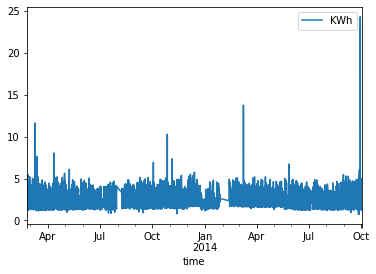

In [2]:
# Remove old raw data file

#!rm "test-cleaned.csv"

# Upload new raw data file

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Read CSV in dataframe. Columns are: index, time, totalKWh, KWh
# index: a sequence increasing from 0 to the maximum number of entries
# time: time corresponding to the reading. Every 15 minutes: 00, 15, 30, 45
# totalKWh: sum of KWh so far (consumed energy)
# kWh: energy consumed during the last interval (usually 15 minutes)

# Notice that this time the separator is a comma , instead of a semicolon ; as it was in the case of the original not cleaned data
raw_df = pd.read_csv('test-cleaned.csv',',')

raw_df.columns = ['index', 'time', 'totalKWh', 'KWh']

raw_df['time']= pd.to_datetime(raw_df['time'], infer_datetime_format=True)

# We set the index as we will be using it later in the last step of this example
raw_df.set_index('index')

print(raw_df)

# Plot raw data
raw_df.plot(x='time', y='KWh')


# Time series decomposition into seasonal, trend, and residual values

We can now proceed to getting the first piece of information from our data. For this we can decompose the time series into its seasonal, trend, and residual components by using an additive model. In plain words that means that we can rewrite our time series as a sum of the three mentioned components:

*original_data = trend_data + seasonal_data + residual_data*

So what does each tell us?



*   **Trend** enables us to discover the increasing or decreasing pattern in the time series
*   **Seasonality** enables us to discover cyclic patterns
*   **Residual** values enable us to observe random variability in the data

In Python we can achieve this automatically through the *seasonal_decompose* method which takes many parameters but we will focus on the one called *freq* which should be selected based on a *logical assumption on the data*. In our case the time series data could have a weekly frequency as this follows most of our working week. Other frequencies could be monthly (30 days), seasonal (90 days), or yearly (365 days). For this example I have decided on a weekly frequency.


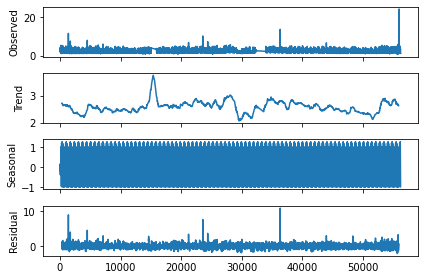

In [3]:
# We assume a frequency of 7 days and since we have 4 readings per hour and 24 hours per day we have 4*24*7=672 entries
decomposed_all_df = seasonal_decompose(raw_df['KWh'], model='additive', freq=672) 

decomposed_all_df.plot()
plt.show()

The plot above is rather packed as it contains lots of values making it unreadable. We could zoom in (I have exampled how to do this in my example on data cleaning) or just focus on a specific interval as I will show next. 

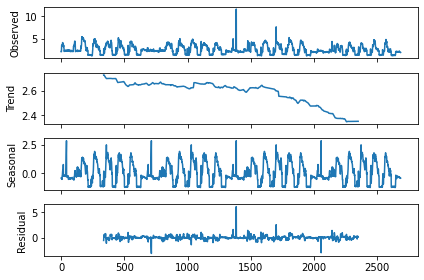

In [4]:
# Use the first month of data: 4 readings per hour x 24 hours x 28 days = 2688
top_raw_df = raw_df.head(2688)

decomposed_top_df = seasonal_decompose(top_raw_df['KWh'], model='additive', freq=672) 

decomposed_top_df.plot()
plt.show()

Let us take a closer look at the weekly and monthly seasonality easily visible by viewing the data directly:

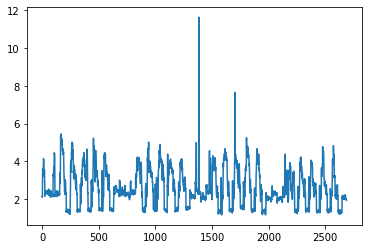

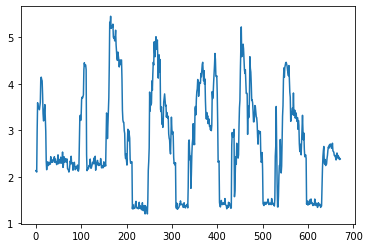

In [5]:
# Plot one month to emphasize weekly seasonality
top_raw_df['KWh'].plot()
plt.show()

# Plot one week to emphasize daily seasonality
top_raw_df.head(672)['KWh'].plot()
plt.show()

By analyzing the CSV file we see that the time series starts on a Saturday afternoon at 16:30 showing low consumption on weekends except two spikes on both Saturday and Sunday evenings lasting until 22:00. The consumption during weekdays clearly shows the increased consumption during daytime (approx. 07:30 - 15:30). When working with time series from different customers you will notice that each will exhibit its own consumption pattern as you already might have noticed from this post's featured image.

You can easily notice that the two sets of decomposed plots are different the reason being that the second is a subset of the first. 

Both plots show the *seasonal* pattern of the data. The *trend* seems overall stable but for the subset shows a tendency to decrease.

# Investigating the stationarity of the time series

This preliminary analysis is good at providing an insight on whether or not the time series is **stationary**, that is *its properties (like mean and variance) do not depend on time*. In our case we want to avoid effects of seasonality and trend since we will use later the data for making various predictions on it.

## Method 1: visual analysis

The example for the subset seems to indicate (see decomposition plot above) a trend and seasonality which could *indicate* that it is not stationary but more tests are needed as I will show next. For the entire dataset we also notice some seasonal patterns which also seem to *indicate* that the time series is not stationary.

You can read more and see some confusing examples on stationary time series [here](https://otexts.com/fpp2/stationarity.html).

## Method 2: Simple statistics: histogram, mean, and variance

Another clue on the stationarity of a time series that we can check is the shape of its histogram. If it is nice Gaussian (bell-like) shaped then there are chances for the data to be stationary. In our cases we see that this is not the case *so perhaps the data is not stationary*?

But why do we look at the histogram? Let us find out next.

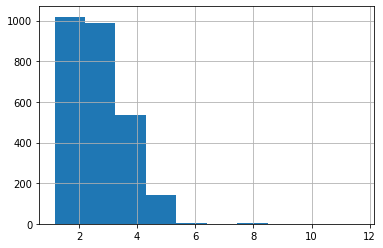

In [6]:
top_raw_df['KWh'].dropna().hist()
plt.show()

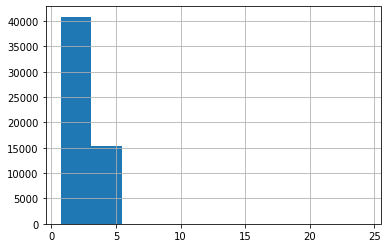

In [8]:
raw_df['KWh'].hist()
plt.show()

The next clue on the stationarity of the time series is obtained by looking at some simple statistics such as **mean** and **variance** across various parts of the data. Since our assumption is that the mean and variance do not depend on time they should be close if we compute them say on each half of the time series. In addition when discussing about mean and variance we usually expect a Gaussian distribution hence the bell shaped histogram that we looked for in our previous plots.

Below you can see the values for the subset involving the first month of readings and those for the entire data:

In [10]:
X_top =top_raw_df['KWh'].values
X = raw_df['KWh'].values
split = round(len(X) / 2)
X1, X2 = X_top[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=2.577999, mean2=2.558993
variance1=0.993099, variance2=0.657854


In [11]:
X_all =raw_df['KWh'].values
split = round(len(X) / 2)
X1, X2 = X_all[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=2.621521, mean2=2.558993
variance1=0.740661, variance2=0.657854


## Statistical tests: ADF and KPSS

I will now introduce 2 complementary statistical tests both testing the **null hypothesis**. The results can be interpreted based on the **p-value**, the probability of obtaining results at least as extreme as the observed results of a statistical hypothesis test, assuming that the null hypothesis is correct. From this we infer that *a small p-value leads to a small probability of the null hypothesis to be true* and we can safely reject it.

1.   **Augmented Dickey-Fuller (ADF) test**. It checks for the unit root and if found then the time series is deemed not stationary. **The null hypothesis is** the presence of the unit root or **that the series is not stationary**. In other words if **p-value < 0.05** then the **time series is stationary** (stochastic trend).
2.   **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**. Tests for the stationarity of a given series around a deterministic trend (a slope in the time series which is temporary). **The null hypothesis is that the series is trend stationary** (stationary around a deterministic trend). In other words if **p-value < 0.05** then the **time series is NOT stationary**.

You can read an interesting article on ADF and KPSS and what to do if they seem to contradict themselves [here](https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/). 

If both tests conclude that the series is stationary then it is so. If both connclude it isn't then it is not stationary. 

But do we do when only a test is passed (*null hypothesis is rejected*)? Well, it depends on the test.

If it **passes the ADF test** (null hypothesis is rejected and the time series is difference stationary) then we apply differencing to make it stationary.
If it **fails the KPSS** (null hypothesis is accepted and the time series is trend stationary) test we apply de-trending to make it stationary.

You can read an article on trend vs difference stationarity [here](https://www.mathworks.com/help/econ/trend-stationary-vs-difference-stationary.html).


Next we apply both tests on the entire time series:

In [16]:
result = adfuller(X_all)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# NULL hypothesis is that the series is NOT stationary 
if (result[1] < 0.05):
  print('Series is difference stationary')
else:
  print('Series is NOT stationary')

ADF Statistic: -28.557953
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Series is difference stationary


In [17]:
# Notice the regression='ct' option to test for stationarity around the trend
result = kpss(X_all, regression='ct')
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key,value in result[3].items():
	print('\t%s: %.3f' % (key, value))

# NOTE that for KPSS the test for the NULL hypothesis is the reverse of ADF
# That is: NULL hypothesis is that the series IS stationary
if (result[1] < 0.05):
  print('Series is NOT stationary')
else:
  print('Series is trend stationary')

KPSS Statistic: 0.638607
p-value: 0.010000
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
Series is NOT stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


As you noticed the series passed both tests meaning that it is *difference stationary* (from the ADF test).

## Making the time series stationary

As a result we should perform *differencing* on it to make it strict stationary. This can be done by subtracting from each value its predecessor.

0        0.00
1       -0.03
2        0.88
3        0.61
4       -0.09
         ... 
56184   -0.11
56185    0.05
56186    0.13
56187   -0.11
56188    0.08
Length: 56189, dtype: float64


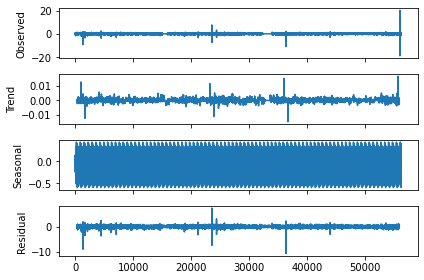

In [14]:
#detrend_df['KWh'] = raw_df['KWh'] - raw_df['KWh'].shift(1)

X = raw_df['KWh'].values
detrend = list()
for i in range(1, len(X)):
	value = X[i] - X[i - 1]
	detrend.append(value)
detrend_series = pd.Series(detrend)

print(detrend_series)

result = seasonal_decompose(detrend_series.dropna(), model='additive', freq=672) 

result.plot()
plt.show()


Compare the plot with the initial one on the cleaned data.

Now let us run again the KPSS test to check if it fails now (null hypothesis is accepted so the series is stationary):

In [15]:
X_all_detrended = detrend_series.dropna().values
result = kpss(X_all_detrended, regression='ct')
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key,value in result[3].items():
	print('\t%s: %.3f' % (key, value))

# NOTE that for KPSS the test for the NULL hypothesis is the reverse of ADF
# That is: NULL hypothesis is that the series IS stationary
if (result[1] < 0.05):
  print('Series is NOT stationary')
else:
  print('Series is trend stationary')

KPSS Statistic: 0.000491
p-value: 0.100000
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
Series is trend stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


At this point our time series is stationary in both tests hence its properties are not time dependent. This improves the accuracy of some prediction methods as some assume a stationary data as input. But more on this in a future post.

In a sense, making the time series stationary is part of the data cleaning and preparation. You should from now on use the data you have in the *final_ts* series and not the original *raw_df* dataframe.

You should **exercise caution** as **detrending might have caused some negative values to appear** which in smart grid translates to negative consumption which is incorrect. You should therefore translate the data by the lowest negative value to obtain positive (including 0) consumption readings.

In [ ]:
# Check for negatives
print("Smallest KWh value = ", detrend_series.min())

final_series = detrend_series.dropna().values + abs(detrend_series.min())

print(final_series)
print('The series has ', len(final_series), ' elements')

# Check that we do not have any more negative values
print("Smallest KWh value after translating them = ", final_series.min())

Smallest KWh value =  -18.9
[18.9  18.87 19.78 ... 19.03 18.79 18.98]
The series has  56189  elements
Smallest KWh value after translating them =  0.0


# Some final thoughts

You might have noticed that from a dataframe with four columns we ended up with a series of just one containing the KWh readings. From this point on we do not really need anything else than this ordered list. However if you feel you will require other information such as the timestamp you could merge the resulted *final_ts* series with the initial dataframe. The *final_ts* contains all initial values except possibly the first one if detrending was perfored.

The reason I am saying this is that the ML algorithms I will cover in a future post do not require time explicitly. In addition, while the simple ISO models I will be discussing require the time of day we can easily infer it based on the indices knowing for instance, that for 16:00 on Wednesday we can get the value at the same hour a week before by looking an an index 672 positions before it (4 readings per hour x 24 hours a day x 7 days in a week). This is only possible if the data has been [properly cleaned](https://saveawatthour.com/index.php/2021/07/15/cleaning-up-smart-grid-data-with-examples/) as I showed in my previous post. 

Next I show how you can create a new dataframe containing the time and detrended data.

                     time    KWh
1     2013-02-23 16:45:00  18.90
2     2013-02-23 17:00:00  18.87
3     2013-02-23 17:15:00  19.78
4     2013-02-23 17:30:00  19.51
5     2013-02-23 17:45:00  18.81
...                   ...    ...
56185 2014-10-01 22:45:00  18.79
56186 2014-10-01 23:00:00  18.95
56187 2014-10-01 23:15:00  19.03
56188 2014-10-01 23:30:00  18.79
56189 2014-10-01 23:45:00  18.98

[56189 rows x 2 columns]


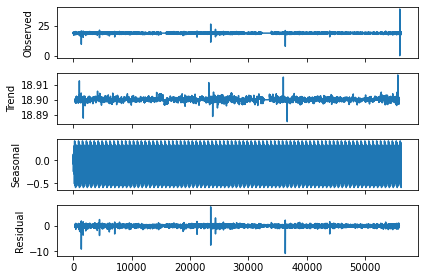

In [ ]:
new_df = pd.DataFrame(columns=['time', 'KWh'])
time = raw_df['time']

# If detrending was performe then the lenghts of the two time series are not equal
# and they should differ by one 
if (len(time) - len(final_series) == 1):
  # we match them by removing the first time entry as it was removed by the detrending
  new_df['time'] = time[1:]
  new_df['KWh'] = final_series

print(new_df)

seasonal_decompose(new_df['KWh'], model='additive', freq=672).plot()
plt.show()
